# Conversion of profiles from pixel-space to q-space

## Main code

Here is a step-by-step example of Python code to convert profiles from pixel space to q-space using the previously described formulae. The complete program can be found in the Jupyter Notebook `conversion-pixel-q-space.ipynb`, available [here](../../../_static/giwaxs/gidvis/results_gidvis.zip).

Below are the functions used to import and process the data:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_qxy(x, lambda_, pixel_size, pos_direct_x, D, PONI_x, delta):
    # Calculate the position of the direct beam on the rotated detector
    pos_direct_x = PONI_x - (D / pixel_size) * np.tan(np.radians(delta))
    
    # Calculate the angle theta for each pixel with horizontal coordinate x
    theta = np.arctan(pixel_size * (x - pos_direct_x) / D)/2.
    
    # Calculate q_xy
    qxy = (4 * np.pi / lambda_) * np.sin(theta)
    
    return qxy

def calculate_qz(y, lambda_, pixel_size, pos_direct_y, D, PONI_y, gamma, alpha_i):
    # Calculate the position of the direct beam on the rotated detector
    pos_direct_y = PONI_y + (D / pixel_size) * np.tan(np.radians(gamma))
    
    # Calculate the final angle alpha_f for each pixel with vertical coordinate y
    alpha_f = np.arctan((pixel_size * (pos_direct_y - y)) / D) - np.radians(alpha_i)
    
    # Calculate q_z
    qz = (2 * np.pi / lambda_) * (np.sin(alpha_f) + np.sin(np.radians(alpha_i)))
    
    return qz

# Function to load the data from a CSV file (one-line header, space-separated)
def load_data(file_path):
    # Load the file with numpy, assuming it's space-separated and has a single-line header
    data = np.loadtxt(file_path, delimiter=None, skiprows=1)
    
    # The first column represents pixel values and the second column represents intensity values
    x_values = data[:, 0]  # Column 0 as pixel values
    intensity_values = data[:, 1]  # Column 1 as intensity values
    
    return x_values, intensity_values

# Process data for q_xy or q_z
def process_file(file_path, lambda_, pixel_size, D, PONI_x, delta, PONI_y=None, gamma=None, alpha_i=None):
    # Load the data from the file
    pixel_values, intensity_values = load_data(file_path)
    
    if gamma is None:
        # Calculate q_xy for each pixel value
        qxy_values = np.array([calculate_qxy(x, lambda_, pixel_size, 0, D, PONI_x, delta) for x in pixel_values])
        # Combine the results
        processed_data = np.column_stack((qxy_values, intensity_values))
    else:
        # Calculate q_z for each pixel value
        qz_values = np.array([calculate_qz(y, lambda_, pixel_size, 0, D, PONI_y, gamma, alpha_i) for y in pixel_values])
        # Combine the results
        processed_data = np.column_stack((qz_values, intensity_values))
    
    return processed_data


The parameters for the beamtime, using the same information you have set up in GIDVis, should be provided as follows:

In [2]:

# Parameters from the beamtime experiment
lambda_ = 1.24e-10  # Wavelength in meters
pixel_size = 172e-6  # Pixel size in meters
D = 0.35  # Distance between detector and sample in meters
PONI_x = 563.5  # Example value for PONI_x
delta = -8.7  # In-plane angle in degrees
PONI_y = 1015  # Example value for PONI_y
alpha_i = 0.12  # Incident angle in degrees

# Paths to files
# In-plane file
file_path_qxy = '5151-pixel-integration-horizontal.txt'

# First out-of-plane angle and file
gamma_1 = -0.75  # Out-of-plane angle in degrees
file_path_qz_1 = '5151-pixel-integration-vertical.txt'
# Second out-of-plane angle and file
gamma_2 = -1.4  # Out-of-plane angle in degrees
file_path_qz_2 = '5152-pixel-integration-vertical.txt'



You can see that the path to the profile along the horizontal direction of the detector is included. Additionally, the paths to the two profiles obtained at the two out-of-plane angles of the detector are specified, along with the corresponding angles at which they were measured.

Next, we process the files, convert them to the appropriate units, and save the results in `.csv` files, which can then be opened with any standard software.

In [3]:
# Process the files
processed_data_qxy = process_file(file_path_qxy, lambda_, pixel_size, D, PONI_x, delta)
processed_data_qz_1 = process_file(file_path_qz_1, lambda_, pixel_size, D, None, None, PONI_y, gamma_1, alpha_i)
processed_data_qz_2 = process_file(file_path_qz_2, lambda_, pixel_size, D, None, None, PONI_y, gamma_2, alpha_i)

# Convert q_xy to Å^-1 for q_xy, and make qxy > 0
processed_data_qxy[:, 0] = processed_data_qxy[:, 0] * 1e-10 * -1

# Convert q_z to Å^-1 for q_z
processed_data_qz_1[:, 0] = processed_data_qz_1[:, 0] * 1e-10
processed_data_qz_2[:, 0] = processed_data_qz_2[:, 0] * 1e-10

# Save the results to new files
np.savetxt('5151-processed-data-qxy.csv', processed_data_qxy, delimiter=';', header="q_xy(A^-1);Intensity", comments='', fmt='%f')
np.savetxt('5151-processed-data-qz.csv', processed_data_qz_1, delimiter=';', header="q_z(A^-1);Intensity", comments='', fmt='%f')
np.savetxt('5152-processed-data-qz.csv', processed_data_qz_2, delimiter=';', header="q_z(A^-1);Intensity", comments='', fmt='%f')

## Plotting and comparing the results

###  In-plane profiles: directly from q-Space and after pixel-space conversion

Here, we compare the results obtained via direct integration in q-space using GIDVis and those derived after conversion from pixel-space.

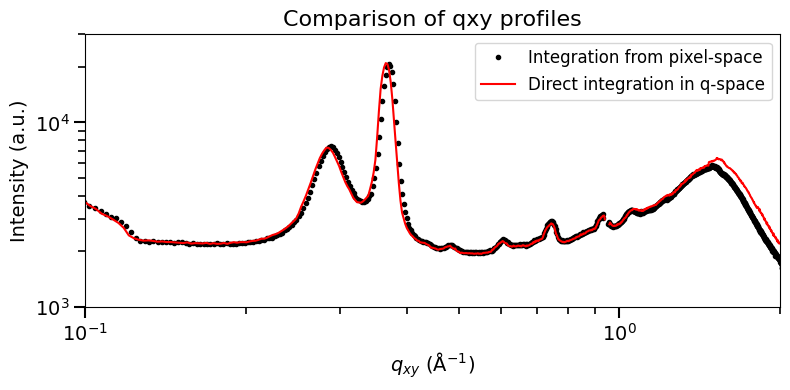

In [4]:
# Load the integration done in GIDVis
data = np.loadtxt('5151-5152-direct-integration-qxy.txt', delimiter=None, skiprows=1)

# The first column represents qxy values and the second column represents intensity values
qxy_direct_values = data[:, 0] *-1 
intensity_direct_values_qxy = data[:, 1]  

plt.figure(figsize=(8, 4))
plt.plot(processed_data_qxy[:, 0], processed_data_qxy[:, 1], 'k.', label="Integration from pixel-space")
plt.plot(qxy_direct_values, intensity_direct_values_qxy, 'r-', label="Direct integration in q-space")

plt.yscale('log')
plt.xscale('log')

plt.xlim(0.1, 2)
plt.ylim(1e3, 3e4)

plt.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12, length=5, width=1.2)

plt.xlabel("$q_{xy}$ ($\mathrm{\AA^{-1}}$)", fontsize=14)
plt.ylabel("Intensity (a.u.)", fontsize=14)
plt.title("Comparison of qxy profiles", fontsize=16)

plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('integration-comparison-qxy-profiles.png')
plt.show()

The results are quite similar, with differences primarily arising from slight variations in the integration domain between pixel-space and q-space.


### Out-of-plane profiles from pixel-space conversion

First, we compare the out-of-plane profiles obtained from two detector positions.

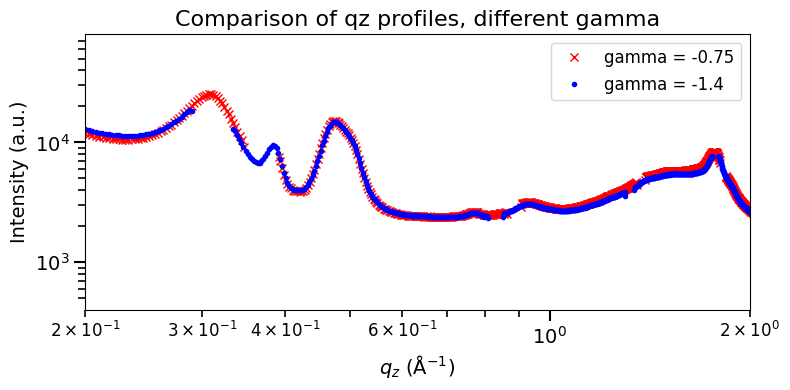

In [5]:
plt.figure(figsize=(8, 4))
plt.plot(processed_data_qz_1[:, 0], processed_data_qz_1[:, 1], 'rx', label="gamma = -0.75")
plt.plot(processed_data_qz_2[:, 0], processed_data_qz_2[:, 1], 'b.', label="gamma = -1.4")

plt.yscale('log')
plt.xscale('log')

plt.xlim(0.2, 2)
#plt.ylim(1e3, 3e4)

plt.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12, length=5, width=1.2)

plt.xlabel("$q_{z}$ ($\mathrm{\AA^{-1}}$)", fontsize=14)
plt.ylabel("Intensity (a.u.)", fontsize=14)
plt.title("Comparison of qz profiles, different gamma", fontsize=16)

plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('integration-comparison-qz-profiles-gamma.png')
plt.show()

To address the missing peak at approximately 3.6 ${\rm nm}^{-1}$ in the curve at `gamma = -0.75`, we use the data measured at `gamma = -1.4` to fill this gap.

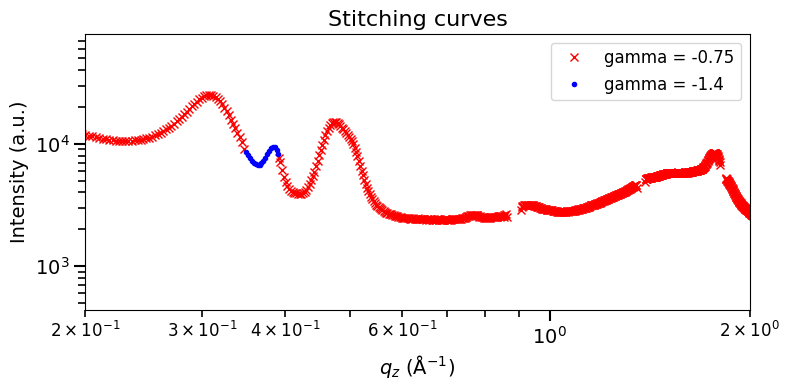

In [6]:
plt.figure(figsize=(8, 4))

plt.plot(processed_data_qz_1[:, 0], processed_data_qz_1[:, 1], 'rx', label="gamma = -0.75")

i_min = 807
i_max = 825
plt.plot(processed_data_qz_2[:, 0][i_min:i_max], processed_data_qz_2[:, 1][i_min:i_max], 'b.', label="gamma = -1.4")

plt.yscale('log')
plt.xscale('log')

plt.xlim(0.2, 2)
#plt.ylim(1e3, 3e4)

plt.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12, length=5, width=1.2)

plt.xlabel("$q_{z}$ ($\mathrm{\AA^{-1}}$)", fontsize=14)
plt.ylabel("Intensity (a.u.)", fontsize=14)
plt.title("Stitching curves", fontsize=16)

plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('integration-comparison-qz-profiles-stitching.png')
plt.show()

We stitch the data together and save the combined profile in the file `5151-5152-stitched-data-qz.csv`.

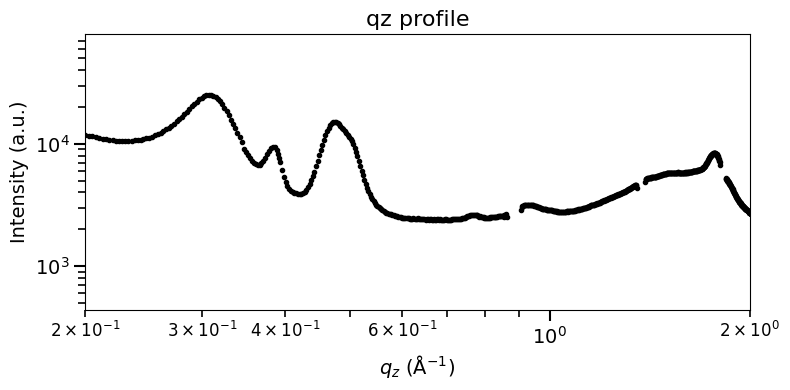

In [7]:
# Combine the two datasets
combined_qz = np.concatenate([processed_data_qz_1[:, 0], processed_data_qz_2[:, 0][i_min:i_max]])
combined_intensity = np.concatenate([processed_data_qz_1[:, 1], processed_data_qz_2[:, 1][i_min:i_max]])

# Combine into a single array for saving
stitched_data = np.column_stack((combined_qz, combined_intensity))

# Save to a new file
np.savetxt('5151-5152-stitched-data-qz.csv', stitched_data, delimiter=';', header='qz,Intensity', comments='', fmt='%f')

plt.figure(figsize=(8, 4))
plt.plot(combined_qz, combined_intensity, 'k.')

plt.yscale('log')
plt.xscale('log')

plt.xlim(0.2, 2)
#plt.ylim(1e3, 3e4)

plt.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12, length=5, width=1.2)

plt.xlabel("$q_{z}$ ($\mathrm{\AA^{-1}}$)", fontsize=14)
plt.ylabel("Intensity (a.u.)", fontsize=14)
plt.title("qz profile", fontsize=16)

#plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('integration-comparison-qz-profiles-stitched.png')
plt.show()

### Comparison in-plane and out-of-plane profiles

An insightful visualization compares the in-plane and out-of-plane profiles, which can reveal information about the sample's organization (e.g., face-on versus edge-on orientation). However, a detailed interpretation of this type of plot is beyond the scope of this tutorial and is best suited for users with expertise in the specific system being measured.

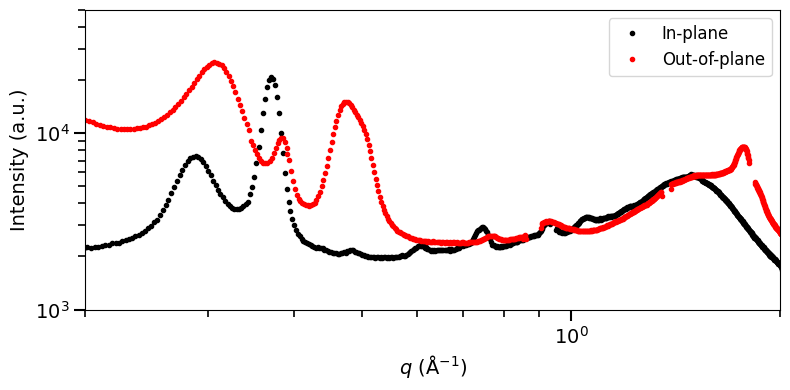

In [8]:
data_qz = np.loadtxt('5151-5152-stitched-data-qz.csv', delimiter=';', skiprows=1)
qz = data_qz[:,0]
qz_intensity = data_qz[:,1]

data_qxy = np.loadtxt('5151-processed-data-qxy.csv', delimiter=';', skiprows=1)
qxy = data_qxy[:,0]
qxy_intensity = data_qxy[:,1]

plt.figure(figsize=(8, 4))
plt.plot(qxy, qxy_intensity, 'k.', label="In-plane")
plt.plot(qz, qz_intensity, 'r.', label = 'Out-of-plane')

plt.yscale('log')
plt.xscale('log')

plt.xlim(0.2, 2)
plt.ylim(1e3, 5e4)

plt.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12, length=5, width=1.2)
plt.tick_params(axis='x', which='minor', labelbottom=False)

plt.xlabel("$q$ ($\mathrm{\AA^{-1}}$)", fontsize=14)
plt.ylabel("Intensity (a.u.)", fontsize=14)

plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('integration-comparison-in-out-plane.png')
plt.show()